In [115]:
import numpy as np
import h5py
from glob import glob 
from tqdm import tqdm
import os

from matplotlib import rc
rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

# #                                                                                                                                       
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})                                                                                             
mpl.rcParams['text.usetex'] = False
mpl.rcParams.update({'xtick.labelsize': 18})
mpl.rcParams.update({'ytick.labelsize': 18})
mpl.rcParams.update({'axes.labelsize': 18})
mpl.rcParams.update({'legend.frameon': False})
mpl.rcParams.update({'lines.linewidth': 2})

import matplotlib.pyplot as plt
import mplhep as hep
hep.set_style(hep.style.CMS)
hep.style.use("CMS")

from matplotlib.lines import Line2D

In [116]:
# all required files
cluster = "nersc"
if cluster == "chicagoAI":
    hepData = "/home/badea/e+e-/aleph/data/HEPData-ins636645-v1-Table_54.csv"
    dataProcessedDir = "/home/badea/e+e-/aleph/data/processed/"
    # omnifold weights
    weightsDir = "/home/badea/e+e-/aleph/OmniFold/scripts/results/"
    paths = [
        ["systematic", os.path.join(weightsDir, "training-6d5bf9d4/*/omnifold_weights.h5")], # systematic variations
        ["bootstrap_mc", os.path.join(weightsDir, "training-8379b835/*/omnifold_weights.h5")], # bootstrap mc 
        ["bootstrap_data", os.path.join(weightsDir, "training-45166dfb/*/omnifold_weights.h5")], # bootstrap data
        ["ensemble", os.path.join(weightsDir, "training-315e385c/*/omnifold_weights.h5")], # ensemble
    ]
elif cluster == "nersc":
    hepData = "/global/homes/b/badea/aleph/data/HEPData-ins636645-v1-Table_54.csv"
    dataProcessedDir = "/global/homes/b/badea/aleph/data/processed/"
    # omnifold weights
    weightsDir = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/"
    paths = [
        # ["systematic", os.path.join(weightsDir, "training-6d5bf9d4/*/omnifold_weights.h5")], # systematic variations
        # ["bootstrap_mc", os.path.join(weightsDir, "training-8379b835/*/omnifold_weights.h5")], # bootstrap mc 
        # ["bootstrap_data", os.path.join(weightsDir, "training-45166dfb/*/omnifold_weights.h5")], # bootstrap data
        # ["ensemble", os.path.join(weightsDir, "training-3045c040/*/model*/omnifold_weights.h5")], # ensemble with no track selections
        ["ensemble", os.path.join(weightsDir, "training-d60880ef/*/model*/omnifold_weights.h5")], # ensemble with nominal track selection
    ]

In [117]:
# function for getting histograms from observable values
def calc_hist(vals, bins=10, weights=None, density=True):
    
    if weights is None:
        weights = np.ones(vals.shape)
    
    # compute histogram
    hist, bins = np.histogram(vals, bins=bins, weights=weights)
    
    # compute which bins the values are in
    digits = np.digitize(vals, bins)

    # compute the errors per bin
    # note that lowest bin value that digitize returns is 1
    # hence the range in the following list comprehension should start at 1
    errs = np.asarray([np.linalg.norm(weights[digits==i]) for i in range(1, len(bins))])

    # handle normalization
    if density:
        binwidths = bins[1:] - bins[:-1]
        density_int = weights.sum() * binwidths # (bins[1] - bins[0])
        hist /= density_int
        errs /= density_int
        
    return hist, errs, bins

# function to propagate errors on division
def propagate_error_division(A, deltaA, B, deltaB):
    """
    Compute the propagated error for division of two quantities A and B with their uncertainties.

    Parameters:
    A (numpy array): Array of values for A.
    deltaA (numpy array): Array of uncertainties for A.
    B (numpy array): Array of values for B.
    deltaB (numpy array): Array of uncertainties for B.

    Returns:
    numpy array: Array of tuples containing (C, deltaC) for corresponding A, deltaA, B, deltaB.
    """
    C = A / B
    deltaC = C * np.sqrt((deltaA / A)**2 + (deltaB / B)**2)
    return deltaC

In [118]:
# get 2004 aleph measurement
# hepData = "/home/badea/e+e-/aleph/data/HEPData-ins636645-v1-Table_54.csv"

with open(hepData, 'r') as f:
    
    vals = []
    for row in f:
        if row.startswith('#'):
            continue
            
        if row.startswith('T'):
            print(row.strip())
        else:
            vals.append(row.strip().split(','))
            
hepdata = np.asarray(vals, dtype=float)

aleph_bins = 1 - np.append(1.0, hepdata[::-1,1])
aleph_midbins = (aleph_bins[1:] + aleph_bins[:-1])/2
aleph_binwidths = aleph_bins[1:] - aleph_bins[:-1]
aleph_thrust = hepdata[::-1,3]
aleph_thrust_errs = np.linalg.norm(hepdata[::-1,[-1,-3,-5]], axis=1)
assert np.all(aleph_bins[1:] == 1 - hepdata[::-1,1]) and np.all(aleph_bins[:-1] == 1 - hepdata[::-1,2])

aleph_log_bins = np.log(aleph_bins + np.exp(-8))
aleph_log_midbins = (aleph_log_bins[1:] + aleph_log_bins[:-1])/2
aleph_log_binwidths = aleph_log_bins[1:] - aleph_log_bins[:-1]
aleph_log_thrust = aleph_thrust * 0.01 / aleph_log_binwidths
aleph_log_thrust_errs = aleph_thrust_errs * 0.01 / aleph_log_binwidths

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -


In [119]:
# dataProcessedDir = "/home/badea/e+e-/aleph/data/processed/"

# data raw
data = np.load(os.path.join(dataProcessedDir, "data_vals_reco.npy"))
dpass = np.load(os.path.join(dataProcessedDir, "data_pass_reco.npy")).astype(bool)
print(data.shape, dpass.shape, dpass.sum())

# pythia 6 gen
gen = np.load(os.path.join(dataProcessedDir, "MC_vals_truth.npy"))
gpass = np.load(os.path.join(dataProcessedDir, "MC_pass_truth.npy")).astype(bool)
print(gen.shape, gpass.shape, gpass.sum())

# pythia 6 reco
reco = np.load(os.path.join(dataProcessedDir, "MC_vals_reco.npy"))
rpass = np.load(os.path.join(dataProcessedDir, "MC_pass_reco.npy")).astype(bool)
print(reco.shape, rpass.shape, rpass.sum())

# omnifold weights
# weightsDir = "/home/badea/e+e-/aleph/OmniFold/scripts/results/"
# paths = [
#     ["systematic", os.path.join(weightsDir, "training-6d5bf9d4/*/omnifold_weights.h5")], # systematic variations
#     ["bootstrap_mc", os.path.join(weightsDir, "training-8379b835/*/omnifold_weights.h5")], # bootstrap mc 
#     ["bootstrap_data", os.path.join(weightsDir, "training-45166dfb/*/omnifold_weights.h5")], # bootstrap data
#     ["ensemble", os.path.join(weightsDir, "training-315e385c/*/omnifold_weights.h5")], # ensemble
# ]

(1365440,) (1365440,) 1326351
(973769,) (973769,) 973769
(973769,) (973769,) 751861


In [120]:
def histUnfolded(doLog, bins, density):
    
    # loop over list, histogram, save
    u = {}
    for key, path in paths:

        # get file list
        fileList = glob(path)
        
        # loop over to get the counts and errors
        u[key] = {"counts":[], "errs":[]}
        for fName in tqdm(fileList):
            with h5py.File(fName, "r") as f:
                weights = np.array(f['weights'])          
                counts, errs, _ = calc_hist(np.log(1-gen[gpass]) if doLog else gen[gpass], bins=bins, weights=weights[gpass], density=density)
                u[key]["counts"].append(counts)
                u[key]["errs"].append(errs)

    # pick one value as the nominal
    nominal = "boostrap_data" if "boostrap_data" in u.keys() else list(u.keys())[0]
    print(nominal)
    unfolded_counts = u[nominal]["counts"][0]
    

    # compute errors
    errs = {}
    for key, val in u.items():
        sd = np.std(val["counts"],axis=0)
        ave = np.mean(val["counts"],axis=0)
        sd_over_mean = sd # /ave
        errs[key] = sd_over_mean
        
    # add in quadrature
    unfolded_errs = np.sum(np.array(list(errs.values()))**2,0) # systematics, bootstrap_mc, bootstrap_data, ensemble
    unfolded_errs += u[nominal]["errs"][0]**2 # statistical error
    unfolded_errs = np.sqrt(unfolded_errs)
    
    # scale by central value
    unfolded_errs *= unfolded_counts

    return u, errs, unfolded_counts, unfolded_errs

In [121]:
# histogram settings
density = True

# 1-thrust
lin_u, lin_errs, lin_unfolded_counts, lin_unfolded_errs = histUnfolded(doLog=False, bins=(1-aleph_bins)[::-1], density=density)

# log(1-thrust)
log_u, log_errs, log_unfolded_counts, log_unfolded_errs = histUnfolded(doLog=True, bins=aleph_log_bins, density=density)

100%|██████████| 392/392 [01:03<00:00,  6.17it/s]


ensemble


100%|██████████| 392/392 [01:01<00:00,  6.37it/s]

ensemble


In [ ]:
# to-do: need to get this correction factor
# 06/23/24: AB believes we do not need this because we are reweighting straight to gen before
#           because in dataloader.py we use mc_gen = np.stack(MC["tgenBefore_thrust"]).flatten()
# corrs = genbhist/(genhist + 10**-50)

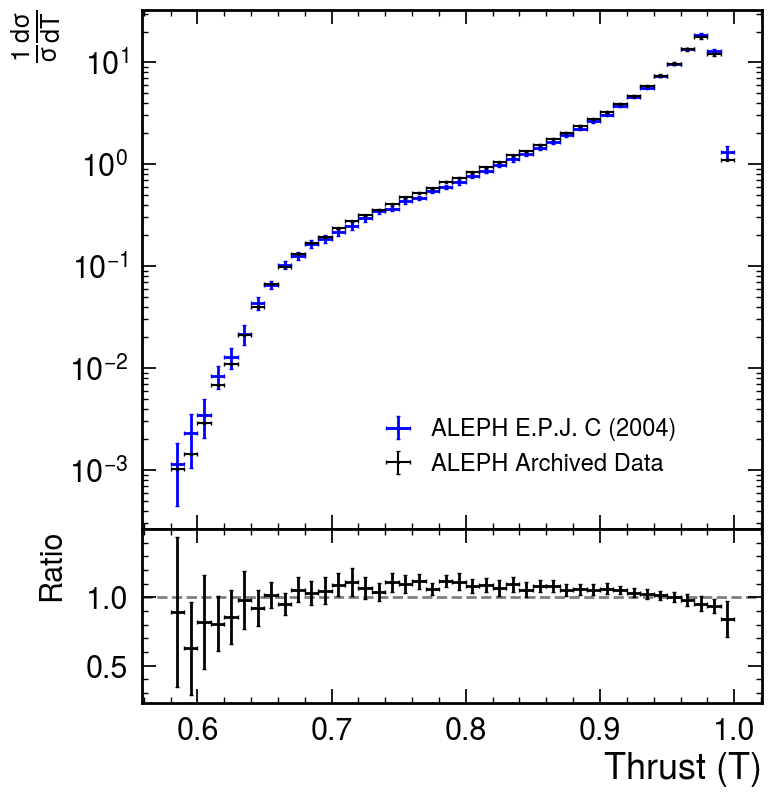

In [128]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,9))
plt.subplots_adjust(hspace=0)

# ALEPH 2004 measurement
ax1.errorbar(1-aleph_midbins, aleph_thrust, color='blue', label='ALEPH E.P.J. C (2004)', 
             xerr=aleph_binwidths/2, yerr=aleph_thrust_errs, fmt='o', 
             lw=2, capsize=1.5, capthick=1, markersize=1.5)

# # ALEPH raw data
# aleph_raw_data_counts, _, _ = ax1.hist(1-data[dpass], bins=aleph_bins, color='black', 
#                                        label='ALEPH Raw 1994 Data', histtype = 'step', 
#                                        lw=2, zorder= 2, density=density)

# # Pythia 6 Gen
# gen_counts, _, _ = ax1.hist(1-gen[gpass], bins=aleph_bins, color='blue', 
#                             label='Pythia 6 Gen', histtype = 'step', 
#                             lw=2, zorder= 2, density=density)

# # Pythia 6 Reco
# reco_counts , _, _ = ax1.hist(1-reco[rpass], bins=aleph_bins, color='orange', 
#                               label='Pythia 6 + Geant 3 Sim.', histtype = 'step', density=density)

# Unfolded distribution
ax1.errorbar(1-aleph_midbins, lin_unfolded_counts[::-1], # NOTE: [::-1] is used to match order of aleph_thrust from high to low thrust values
             color='black', label='ALEPH Archived Data', 
             xerr=aleph_binwidths/2, yerr=lin_unfolded_errs[::-1], 
             fmt='o', lw=1.5, capsize=1.5, capthick=1, markersize=1.5)

ax1.legend()

# Bottom subplot (ratio plot)
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5)  # Adding a horizontal line at y=1 for reference

# get gen errors
# _, gen_errs, _ = calc_hist(1-gen[gpass], bins=aleph_bins, density=True)

# # ALEPH 2004 measurement ratio
# ax2.errorbar(aleph_midbins, aleph_thrust/(gen_counts+1e-50), 
#              xerr=aleph_binwidths/2,
#              yerr=propagate_error_division(aleph_thrust, aleph_thrust_errs, gen_counts, gen_errs),
#              color='green', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# # ALEPH raw data
# _, aleph_raw_data_errs, _ = calc_hist(1-data[dpass], bins=aleph_bins, density=True)
# ax2.errorbar(aleph_midbins, aleph_raw_data_counts/(gen_counts+1e-50), 
#              xerr=aleph_binwidths/2,
#              yerr=propagate_error_division(aleph_raw_data_counts, aleph_raw_data_errs, gen_counts, gen_errs),
#              color='black', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# # Pythia 6 Reco
# _, reco_errs, _ = calc_hist(1-reco[rpass], bins=aleph_bins, density=True)
# ax2.errorbar(aleph_midbins, reco_counts/(gen_counts+1e-50), 
#              xerr=aleph_binwidths/2,
#              yerr=propagate_error_division(reco_counts, reco_errs, gen_counts, gen_errs),
#              color='orange', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# Unfolded distribution
# ax2.errorbar(aleph_midbins, lin_unfolded_counts/(gen_counts+1e-50), 
#              xerr=aleph_binwidths/2,
#              yerr=propagate_error_division(lin_unfolded_counts, lin_unfolded_errs, gen_counts, gen_errs),
#              color='tab:red', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5, alpha=0.5)

ax2.errorbar(1-aleph_midbins, lin_unfolded_counts[::-1]/aleph_thrust, 
             xerr=aleph_binwidths/2,
             yerr=propagate_error_division(lin_unfolded_counts[::-1], lin_unfolded_errs[::-1], aleph_thrust, aleph_thrust_errs),
             color='black', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5, alpha=1.0)

# tick params
tick_params_major = {"which"     : "major",
                     "length"    : 10,
                     "width"     : 1.25,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 22,
                     "pad"       : 10}
tick_params_minor = {"which"     : "minor",
                     "length"    : 4,
                     "width"     : 1,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 18}
ax1.tick_params(**tick_params_major)
ax1.tick_params(**tick_params_minor)
ax2.tick_params(**tick_params_major)
ax2.tick_params(**tick_params_minor)

# set limits
# ax1.set_ylim(0.2*10**-5, 10**0)
# ax2.set_xlim(0,0.5)
# ax2.set_xlim(-10,0)
# ax2.set_ylim(0.78,1.22)

# log scale
ax1.set_yscale("log")

# axis labels
# ax1.set_ylabel("Density of Events")
ax1.set_ylabel(r'$\frac{1}{\sigma}\frac{d\sigma}{dT}$')
ax2.set_ylabel("Ratio", fontsize=22, labelpad=14)
ax2.set_xlabel(r'Thrust (T)')

# legend
handles, labels = ax1.get_legend_handles_labels()
new_handles = []
for h in handles:
    try:
        new_handles.append(Line2D([], [], linestyle='-', marker='o', c=h.get_edgecolor()))
    except:
        new_handles.append(h)
            
ax1.legend(new_handles,
          labels,
          title="",
          title_fontsize="13",
          ncol=1,
          framealpha=0.0,
          prop={'size': 17},
          bbox_to_anchor=(0.4, 0.01, 0.5, 0.25),
          handlelength=1.25)

# save
plt.savefig("thrust.pdf", bbox_inches="tight")

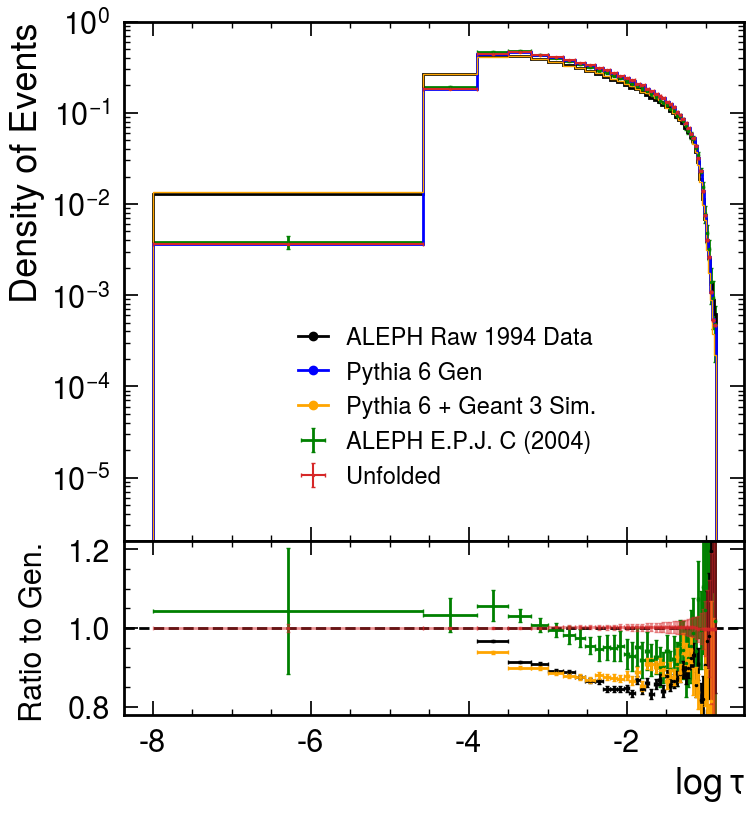

In [129]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,9))
plt.subplots_adjust(hspace=0)

# ALEPH 2004 measurement
ax1.errorbar(aleph_log_midbins, aleph_log_thrust, color='green', label='ALEPH E.P.J. C (2004)', 
             xerr=aleph_log_binwidths/2, yerr=aleph_log_thrust_errs, fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# ALEPH raw data
aleph_raw_data_counts, _, _ = ax1.hist(np.log(1-data[dpass]), bins=aleph_log_bins, color='black', label='ALEPH Raw 1994 Data', histtype = 'step', lw=2, zorder= 2, density=density)

# Pythia 6 Gen
gen_counts, _, _ = ax1.hist(np.log(1-gen[gpass]), bins=aleph_log_bins, color='blue', label='Pythia 6 Gen', histtype = 'step', lw=2, zorder= 2, density=density)

# Pythia 6 Reco
reco_counts , _, _ = ax1.hist(np.log(1-reco[rpass]), bins=aleph_log_bins, color='orange', label='Pythia 6 + Geant 3 Sim.', histtype = 'step', density=density)

# Unfolded distribution
ax1.errorbar(aleph_log_midbins, log_unfolded_counts, color='tab:red', label='Unfolded', xerr=aleph_log_binwidths/2, yerr=log_unfolded_errs, 
             fmt='o', lw=1.5, capsize=1.5, capthick=1, markersize=1.5)

ax1.legend()

# Bottom subplot (ratio plot)
ax2.axhline(y=1, color='black', linestyle='--')  # Adding a horizontal line at y=1 for reference

# get gen errors
_, gen_errs, _ = calc_hist(np.log(1-gen[gpass]), bins=aleph_log_bins, density=True)

# # ALEPH 2004 measurement ratio
ax2.errorbar(aleph_log_midbins, aleph_log_thrust/(gen_counts+1e-50), 
             xerr=aleph_log_binwidths/2,
             yerr=propagate_error_division(aleph_log_thrust, aleph_log_thrust_errs, gen_counts, gen_errs),
             color='green', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# ALEPH raw data
_, aleph_raw_data_errs, _ = calc_hist(np.log(1-data[dpass]), bins=aleph_log_bins, density=True)
ax2.errorbar(aleph_log_midbins, aleph_raw_data_counts/(gen_counts+1e-50), 
             xerr=aleph_log_binwidths/2,
             yerr=propagate_error_division(aleph_raw_data_counts, aleph_raw_data_errs, gen_counts, gen_errs),
             color='black', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# Pythia 6 Reco
_, reco_errs, _ = calc_hist(np.log(1-reco[rpass]), bins=aleph_log_bins, density=True)
ax2.errorbar(aleph_log_midbins, reco_counts/(gen_counts+1e-50), 
             xerr=aleph_log_binwidths/2,
             yerr=propagate_error_division(reco_counts, reco_errs, gen_counts, gen_errs),
             color='orange', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# Unfolded distribution
ax2.errorbar(aleph_log_midbins, log_unfolded_counts/(gen_counts+1e-50), 
             xerr=aleph_log_binwidths/2,
             yerr=propagate_error_division(log_unfolded_counts, log_unfolded_errs, gen_counts, gen_errs),
             color='tab:red', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5, alpha=0.5)

# tick params
tick_params_major = {"which"     : "major",
                     "length"    : 10,
                     "width"     : 1.25,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 22,
                     "pad"       : 10}
tick_params_minor = {"which"     : "minor",
                     "length"    : 4,
                     "width"     : 1,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 18}
ax1.tick_params(**tick_params_major)
ax1.tick_params(**tick_params_minor)
ax2.tick_params(**tick_params_major)
ax2.tick_params(**tick_params_minor)

# set limits
ax1.set_ylim(0.2*10**-5, 10**0)
# ax2.set_xlim(-10,0)
ax2.set_ylim(0.78,1.22)

# log scale
ax1.set_yscale("log")

# axis labels
ax1.set_ylabel("Density of Events")
ax2.set_ylabel("Ratio to Gen.", fontsize=22, labelpad=14)
# ax2.set_xlabel(r'$\log\left(1-T\right)$')
ax2.set_xlabel(r'$\log\tau$')

# legend
handles, labels = ax1.get_legend_handles_labels()
new_handles = []
for h in handles:
    try:
        new_handles.append(Line2D([], [], linestyle='-', marker='o', c=h.get_edgecolor()))
    except:
        new_handles.append(h)
            
ax1.legend(new_handles,
          labels,
          title="",
          title_fontsize="13",
          ncol=1,
          framealpha=0.0,
          prop={'size': 17},
          bbox_to_anchor=(0.35, 0.01, 0.45, 0.45), #(0.54, 0.45, 0.45, 0.5)
          handlelength=1.25)

# add text
# left, top, t = 0.07, 0.94, 0.06
# stamps = [
#     r"higgs portal, $pp \rightarrow h \rightarrow q_{d}q_{d} \; (q_{d} \rightarrow (dark) \; hadrons)$",
#     "arxiv:2103.01238",
#     r"$\mathit{m_{\tilde{\omega}}} = \mathit{m_{\tilde{\eta}}}$",
#     r"$c\tau = 30\; mm \times \left(\frac{5 \; GeV}{\mathit{m_{\tilde{\eta}}}}\right)^{7}$", #  # 5 \; GeV / \mathit{m_{\tilde{\eta}}}
#     r"$L_{xy} < 1000\; mm$",
#     r"$\mathrm{p_{T}}$ > 5 GeV, |$\eta$|<2.4",
# ]
# for i, stamp in enumerate(stamps):
#     ax1.text(left, top - i*t, stamp, fontsize=14, ha='left', va='top', transform=ax1.transAxes)

# save
plt.savefig("log_tau.pdf", bbox_inches="tight")

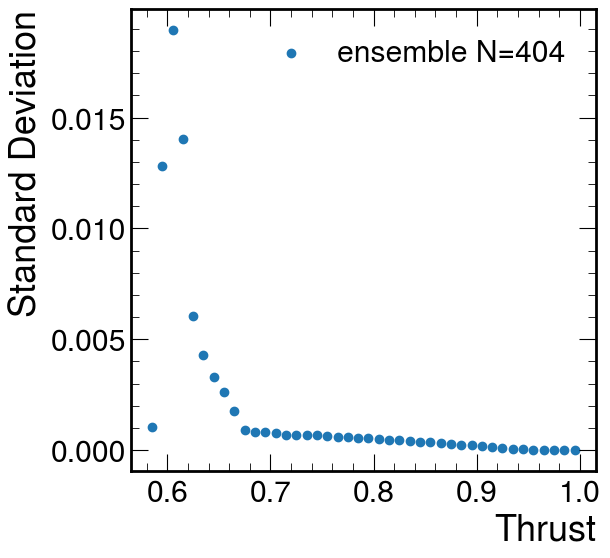

In [130]:
plt.figure(figsize=(6,6))
for key, val in lin_errs.items():
    plt.scatter(1-aleph_midbins, val, label=key + " N=404")
plt.xlabel("Thrust")
plt.ylabel("Standard Deviation")
# plt.ylim(0,0.01)
plt.legend()
plt.savefig("thrust_uncertainty_breakdown.pdf", bbox_inches="tight")

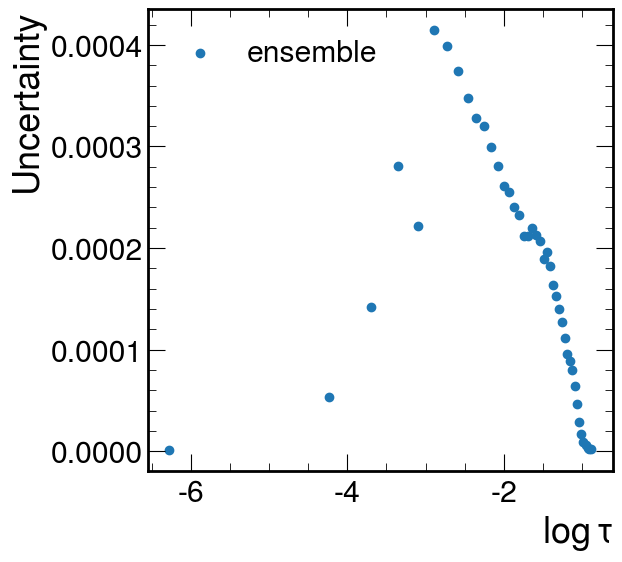

In [131]:
plt.figure(figsize=(6,6))
for key, val in log_errs.items():
    plt.scatter(aleph_log_midbins, val, label=key)
plt.xlabel(r'$\log\tau$')
plt.ylabel("Uncertainty")
plt.legend()
plt.savefig("logtau_uncertainty_breakdown.pdf", bbox_inches="tight")

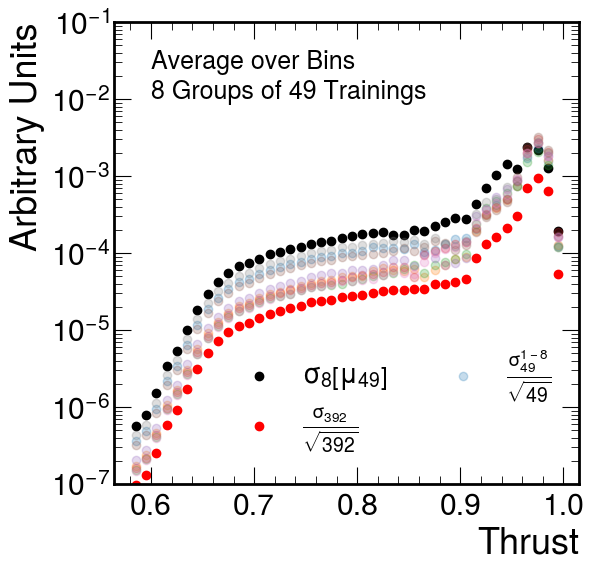

In [133]:
a,b = 8, 49

# pick up errors
ens_cts = np.array(lin_u["ensemble"]["counts"])
ens_cts = ens_cts[:400]
ens_cts = ens_cts.reshape(a, b, 42)

# get means over the 40 ensembeles
ens_cts_mean = np.mean(ens_cts,axis=1)

# get std over the means
ens_cts_mean_std = np.std(ens_cts_mean,axis=0)

# get std within each set of 40
ens_cts_std = np.std(ens_cts,axis=1)
ens_cts_std /= b**0.5

# plot
plt.figure(figsize=(6,6))
plt.scatter(1-aleph_midbins, ens_cts_mean_std[::-1], label=fr"$\sigma_{{{a}}}\left[\mu_{{{b}}}\right]$", color="black")

ens_cts_all = np.std(ens_cts.reshape(a*b, 42),0)/400**0.5
plt.scatter(1-aleph_midbins, ens_cts_all[::-1], label=fr"$\frac{{\sigma_{{{a*b}}}}}{{\sqrt{{{a*b}}}}}$", color="red")

for i in range(ens_cts_std.shape[0]):
    plt.scatter(1-aleph_midbins, ens_cts_std[i][::-1], label=fr"$\frac{{\sigma_{{{b}}}^{{1-{ens_cts_std.shape[0]}}}}}{{\sqrt{{{b}}}}}$" if i == 0 else "", alpha=0.25)

plt.xlabel("Thrust")
plt.ylabel("Arbitrary Units")
plt.yscale("log")
plt.ylim(10**-7, 10**-1)
plt.text(0.6, 2.5*10**-2, "Average over Bins", fontsize=18)
plt.text(0.6, 10**-2, f"{a} Groups of {b} Trainings", fontsize=18)
plt.legend(fontsize=20, ncol=2, loc="lower right")
plt.savefig(f"ensembeling_std_average_over_bins_{a}_{b}.pdf", bbox_inches="tight")

In [136]:
# loop over list, histogram, save
u = {}

key, path = paths[0]

# get file list
fileList = glob(path)[:400]

# load weights
weights = []
for fName in tqdm(fileList):
    with h5py.File(fName, "r") as f:
        weights.append(np.array(f['weights']))
weights = np.array(weights)
print(weights.shape)

# histogram
counts_1, errs_1 = [], []
for i in tqdm(weights):
    c, e, _ = calc_hist(gen[gpass], bins=bins, weights=i[gpass], density=density)
    counts_1.append(c)
    errs_1.append(e)

counts_1 = np.array(counts_1)
errs_1 = np.array(errs_1)
print(counts_1.shape, errs_1.shape)

100%|██████████| 392/392 [00:01<00:00, 280.58it/s]


(392, 973769)


100%|██████████| 392/392 [01:10<00:00,  5.59it/s]

(392, 42) (392, 42)


(392, 973769)
(26, 15, 973769)


100%|██████████| 26/26 [00:04<00:00,  6.40it/s]

(26, 42) (26, 42)
(26, 15, 42)


Text(0.6, 0.0025, 'Normalize by Bin Value')

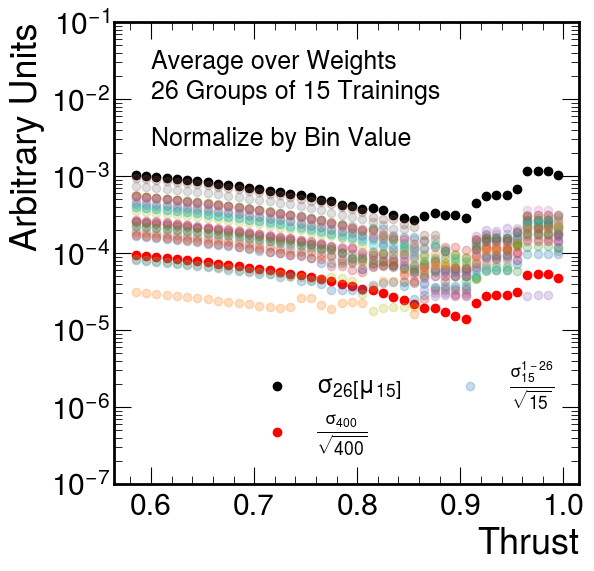

In [152]:
a,b = 26, 15

# bins
bins=(1-aleph_bins)[::-1]

# first do std of mean of 
print(weights.shape)
temp = weights[:a*b].reshape(a, b, -1)
print(temp.shape)
# average over ensembles
temp = np.mean(temp, axis = 1)
# histogram
counts, errs = [], []
for i in tqdm(temp):
    c, e, _ = calc_hist(gen[gpass], bins=bins, weights=i[gpass], density=density)
    counts.append(c)
    errs.append(e)
counts = np.array(counts)
errs = np.array(errs)
print(counts.shape, errs.shape)

# second step
counts_1 = np.array(lin_u["ensemble"]["counts"][:a*b]).reshape(a, b, -1)
print(counts_1.shape)
counts_1_std = np.std(counts_1, axis=1)
counts_1_std /= b**0.5
counts_1_mean = np.mean(counts_1, axis=1)

# make plot
plt.figure(figsize=(6,6))

plt.scatter(1-aleph_midbins, (np.std(counts,axis=0)/np.mean(counts,axis=0))[::-1], label=fr"$\sigma_{{{a}}}\left[\mu_{{{b}}}\right]$", color="black")

counts_1_all_std = np.std(counts_1.reshape(a*b, -1), axis=0)/400**0.5
counts_1_all_mean = np.mean(counts_1.reshape(a*b, -1), axis=0)
plt.scatter(1-aleph_midbins, (counts_1_all_std/counts_1_all_mean)[::-1], label=fr"$\frac{{\sigma_{{400}}}}{{\sqrt{{400}}}}$", color="red")

for i in range(counts_1_std.shape[0]):
    plt.scatter(1-aleph_midbins, (counts_1_std[i]/counts_1_mean[i])[::-1], label=fr"$\frac{{\sigma_{{{b}}}^{{1-{counts_1_std.shape[0]}}}}}{{\sqrt{{{b}}}}}$" if i == 0 else "", alpha=0.25)

plt.xlabel("Thrust")
plt.ylabel("Arbitrary Units")
plt.yscale("log")
plt.ylim(10**-7, 10**-1)
plt.legend(fontsize=18, ncol=2, loc="lower right")
plt.text(0.6, 2.5*10**-2, "Average over Weights", fontsize=18)
plt.text(0.6, 10**-2, f"{a} Groups of {b} Trainings", fontsize=18)
plt.text(0.6, 2.5*10**-3, f"Normalize by Bin Value", fontsize=18)
# plt.savefig(f"ensembeling_std_average_over_weights_{a}_{b}.pdf", bbox_inches="tight")